## Primero de todo los imports

In [177]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

np.random.seed(100)


# Creamos un directiorio para la salida
import os
if not os.path.exists('output'):
    os.makedirs('output')

# KNN
from sklearn import neighbors    
# Linear Regression
from sklearn.linear_model import LinearRegression
# Random Forest
from sklearn.ensemble import RandomForestRegressor

# Para hacer test y train
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split

# Para ajustar los hiper-parámetros
from sklearn.model_selection import GridSearchCV

# Preproceso
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder

# Función de error
from sklearn.metrics import mean_squared_error, r2_score

# Los datos

In [166]:
# Cargamos el dataset
housing = pd.read_csv('dataset/housing-snapshot/train_set.csv',index_col=0) 
print("Número de casas:",housing.shape[0]," Número de características:", housing.shape[1])
housing_num = X_train_rf.select_dtypes(exclude=[np.object]).columns
housing_cat = X_train_rf.select_dtypes(include=[np.object]).columns
print("\n Características numéricas: \n ", list(housing_num))

print("Características categóricas: \n", list(housing_cat))

Número de casas: 5432  Número de características: 21

 Características numéricas: 
  ['Rooms', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 'Lattitude', 'Longtitude', 'Propertycount']
Características categóricas: 
 ['Suburb', 'Address', 'Type', 'Method', 'SellerG', 'Date', 'CouncilArea', 'Regionname']


In [179]:

# Ponemos "Postcode" a categorical, dado que que no es numérica.
housing['Postcode'] = pd.Categorical(housing.Postcode)
housing_num = X_train_rf.select_dtypes(exclude=[np.object]).columns
housing_cat = X_train_rf.select_dtypes(include=[np.object]).columns
# Dividimos haciendo uso de la estratificación para tener una buena proporción.
housing["price_aux"] = pd.cut(housing["Price"],
                               bins=[0., 500000, 1000000, 1500000, 2000000., np.inf],
                               labels=[1, 2, 3, 4, 5])

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["price_aux"]):
    train_set = housing.loc[train_index]
    test_set = housing.loc[test_index]

# Quitamos la etiqueta price_cat
train_set.drop("price_aux", axis=1, inplace=True)
test_set.drop("price_aux", axis=1, inplace=True)
housing.drop("price_aux", axis=1, inplace=True)

# El con el train probaremos los modelos.
X_train = train_set.drop("Price", axis=1).copy()
y_train = train_set["Price"].copy()
# El test no lo tenemos que tocar hasta el final de todo.
X_test = test_set.drop("Price", axis=1).copy()
y_test = test_set["Price"].copy()


## Las funciones de las pipelines

In [180]:
## create a function to replace 0 by NaN
def replace_0_2_NaN(data):
    data[data == 0] = np.nan
    return data


# column index
Rooms_ix, Bedroom2_ix, Bathroom_ix, BuildingArea_ix = 0, 2, 3, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y=None):
        return self  # nothing else to do
    
    def transform(self, X):
        rooms_per_building_area = X[:, Rooms_ix] / (1.0 +X[:, BuildingArea_ix])# add 1 to avoid 0 division
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, Bedroom2_ix] / (1.0 + X[:, Bathroom_ix]) # add 1 to avoid 0 division
            return np.c_[X, rooms_per_building_area, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_building_area]


# Los modelos

Vamos a tratar unos modelos de machine learning y en concreto haremos uso de la famosa librería Sklearn. En cada uno de los distintos modelos vamos a mostrar primero una implementación naíf y luego vamos a hacer un preproceso de datos personalizado, una feature selection y cuando sea posible una optimización de los hiper-parámetros para conseguir los mejores resultados posibles.

# 1. KNN

In [181]:
X_train_knn = X_train.copy()
y_train_knn = y_train.copy()

# 2. Regresión Lineal

In [182]:
X_train_lr = X_train.copy()
y_train_lr = y_train.copy()

# 3. Random Forest

Primero haremos una implementación naíf del modelo:

RMSE 119540.0112525515
R^2:  0.9591052486186264


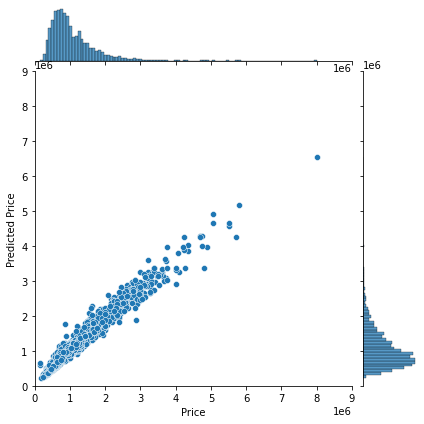

In [184]:
X_train_rf = X_train.copy()
y_train_rf = y_train.copy()



model = RandomForestRegressor(random_state=100)



num_attribs = housing_num

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
])

full_naif_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
])



X_naif_num = full_naif_pipeline.fit_transform(X_train_rf,y_train_rf)

model.fit(X_naif_num, y_train_rf)
y_pred_rf=model.predict(X_naif_num)

rmse=np.sqrt(mean_squared_error(y_pred_rf, y_train_rf))
print("RMSE",rmse)
r2=r2_score(y_pred_rf, y_train_rf)
print("R^2: ",r2)

result = pd.DataFrame({"Price":y_train_rf,
                      "Predicted Price":y_pred_rf})

# I prefer this plot.
sns.jointplot(data=result, x="Price", y="Predicted Price",xlim=(0,9000000),ylim=(0,9000000))#,kind="reg")

In [156]:


#Para las columnas con muchos ceros sin sentido. A las que además se les aplicará la función logaritmo
num0_pipeline = Pipeline([
        ('zeros2NaN',FunctionTransformer(func = replace_0_2_NaN,validate=False)),
        ('imputer', SimpleImputer(strategy="median")),
        ('log',FunctionTransformer(np.log1p, validate=True)),
        ('std_scaler', StandardScaler()),
    ])
#Para las otras columnas numéricas
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])
#Para las variables categóricas. Principalmente utilizaremos el OneHotEncoder
cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="constant",fill_value='Unknown')),
        ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore')),
    ])

"""
Columnas numéricas:  ['Rooms', 'Price', 'Distance', 'Bedroom2', 'Bathroom', 'Car', 
'Landsize', 'BuildingArea', 'YearBuilt', 'Lattitude', 'Longtitude', 'Propertycount']

Columnas categóricas:  ['Suburb', 'Address', 'Type', 'Method', 'SellerG', 'Date', 'CouncilArea', 'Regionname']
"""

#Estas son las columnas seleccionadas en el proyecto base para cada pipeline.
num_attribs0 = ['Landsize','BuildingArea']
num_attribs1 = list(housing_num)
cat_attribs = ["CouncilArea",'Type','Suburb','Postcode']

#Creamos la "full_pipeline", es decir la pipeline que engloba a todas las otras.
full_pipeline = ColumnTransformer([
        ("num0", num0_pipeline, num_attribs0),
        ("num1", num_pipeline, num_attribs1),
        ("cat", cat_pipeline, cat_attribs),
])

#Preprocesamos los datos utilizando la "full_pipeline"
X_train_prepared = full_pipeline.fit_transform(X_train_rf,y_train_rf)
X_train_prepared

<4345x518 sparse matrix of type '<class 'numpy.float64'>'
	with 86900 stored elements in Compressed Sparse Row format>

In [147]:
model = RandomForestRegressor(random_state=100)

In [148]:

rf_param_grid = {
                'max_features': range(8,168,60),
                'n_estimators': [82],
                    #'max_depth': [None],
                   #'bootstrap': [False],
                #"min_samples_split":[2,3],
                #"min_samples_leaf":[1,2],
}
rf_grid_search = GridSearchCV(model, param_grid=rf_param_grid, cv=5,
                           scoring='neg_root_mean_squared_error',
                           return_train_score=True,n_jobs=-1)
rf_grid_search.fit(X_train_prepared, y_train)

print("Best trained model:")
print(rf_grid_search.best_estimator_)
print("Best parameters:")
print(rf_grid_search.best_params_)
print("Best Score")
print(np.sqrt(-rf_grid_search.best_score_),-rf_grid_search.best_score_)

Best trained model:
RandomForestRegressor(max_features=128, n_estimators=82, random_state=100)
Best parameters:
{'max_features': 128, 'n_estimators': 82}
Best Score
550.5597326100665 303116.01917166787
